In [1]:
import os, random, glob, pickle, collections
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

from skimage.data import imread
from skimage.io import imshow,imsave
import cv2
from skimage.util import crop
from skimage.transform import rotate
from skimage.transform import resize
import math

Using TensorFlow backend.


In [2]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../RFCN/JPEGImages/'
TRAIN_CROP_DIR = '../data/train_crop/'
TEST_CROP_DIR = '../data/test_stg1_crop/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
CONF_THRESH = 0.8
ROWS = 224
COLS = 224
BatchSize = 128
LearningRate = 1e-4
le = LabelEncoder()
le.fit(FISH_CLASSES)
le.transform(FISH_CLASSES)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [3]:
#Loading data
import pickle

def get_images(fish):
    """Load files from train folder"""
    fish_dir = TRAIN_CROP_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    im = Image.open(src)
    im = im.resize((COLS, ROWS), Image.BILINEAR)
    im = np.asarray(im)
    return im

if os.path.exists('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_train_BBCrop_{}_{}.pickle. Loading data from file.'.format(ROWS, COLS))
    with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_train = pickle.load(f)
    X_train = data_train['X_train']
    y_train = data_train['y_train']
else:
    print ('Loading data from original images. Generating data_train_BBCrop_{}_{}.pickle.'.format(ROWS, COLS))
    
    files = []
    y_train = []

    for fish in FISH_CLASSES:
        fish_files = get_images(fish)
        files.extend(fish_files)

        y_fish = np.tile(fish, len(fish_files))
        y_train.extend(y_fish)
        #print("{0} photos of {1}".format(len(fish_files), fish))

    y_train = np.array(y_train)
    X_train = np.ndarray((len(files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(files): 
        X_train[i] = read_image(TRAIN_CROP_DIR+im)
        if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

    #X_train = X_train / 255.
    #print(X_train.shape)

    # One Hot Encoding Labels
    y_train = le.transform(y_train)
    y_train = np_utils.to_categorical(y_train)
    
    #save data to file
    data_train = {'X_train': X_train,'y_train': y_train }

    with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_train, f)

#rescale
X_train = X_train / 255.
X_train = X_train.astype(np.float32)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=None, stratify=y_train)

Exist data_train_BBCrop_224_224.pickle. Loading data from file.


In [4]:
X_train.shape

(15583, 224, 224, 3)

In [5]:
#data preprocessing

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    #featurewise_std_normalization=True,
    #rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=[0.9,1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BatchSize, shuffle=True, seed=None)

valid_datagen = ImageDataGenerator(
    featurewise_center=True)
    #featurewise_std_normalization=True)
    #rescale=1./255
valid_datagen.fit(X_valid)   
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=BatchSize, shuffle=True, seed=None)

In [6]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath='./checkpoints/checkpoint2/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir='./logs/log2', histogram_freq=0, write_graph=True, write_images=True)


In [ ]:
#Resnet50
#stg1 training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=30, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Epoch 1/30
15488/15583 [============================>.] - ETA: 1s - loss: 1.6035 - acc: 0.4657

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 1.40994, saving model to ./checkpoints/checkpoint2/weights.000-1.4099.hdf5
15616/15583 [==============================] - 258s - loss: 1.5997 - acc: 0.4674 - val_loss: 1.4099 - val_acc: 0.7684
Epoch 2/30
15616/15583 [==============================] - 248s - loss: 1.2042 - acc: 0.6918 - val_loss: 1.3130 - val_acc: 0.7530
Epoch 3/30
15645/15583 [==============================] - 250s - loss: 1.0546 - acc: 0.7473 - val_loss: 1.2446 - val_acc: 0.7581
Epoch 4/30
15616/15583 [==============================] - 248s - loss: 0.9808 - acc: 0.7554 - val_loss: 1.1963 - val_acc: 0.7629
Epoch 5/30
15616/15583 [==============================] - 247s - loss: 0.9014 - acc: 0.7678 - val_loss: 1.1775 - val_acc: 0.7596
Epoch 6/30
 6528/15583 [===========>..................] - ETA: 115s - loss: 0.8754 - acc: 0.7782

In [10]:
#Resnet50
#stg2 training

# files = glob.glob('./checkpoints/*')
# val_losses = [float(f.split('-')[-1][:-5]) for f in files]
# index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file weights.028-0.4157.hdf5')
model = load_model('./checkpoints/checkpoint2/weights.028-0.4157.hdf5')

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
#164
for layer in model.layers[:142]:
   layer.trainable = False
for layer in model.layers[142:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file weights.028-0.4157.hdf5
0 input_1
1 zeropadding2d_1
2 conv1
3 bn_conv1
4 activation_1
5 maxpooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 merge_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 merge_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 merge_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 merge_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c


/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from 0.41571 to 0.22631, saving model to ./checkpoints/checkpoint2/weights.000-0.2263.hdf5
15616/15583 [==============================] - 296s - loss: 0.2269 - acc: 0.9276 - val_loss: 0.2263 - val_acc: 0.9274
Epoch 2/300
15616/15583 [==============================] - 279s - loss: 0.1271 - acc: 0.9605 - val_loss: 0.1506 - val_acc: 0.9483
Epoch 3/300
15645/15583 [==============================] - 283s - loss: 0.0818 - acc: 0.9746 - val_loss: 0.1408 - val_acc: 0.9619
Epoch 4/300
15616/15583 [==============================] - 280s - loss: 0.0592 - acc: 0.9817 - val_loss: 0.0761 - val_acc: 0.9768
Epoch 5/300
15616/15583 [==============================] - 280s - loss: 0.0499 - acc: 0.9838 - val_loss: 0.0565 - val_acc: 0.9844
Epoch 6/300
15645/15583 [==============================] - 280s - loss: 0.0470 - acc: 0.9856 - val_loss: 0.0788 - val_acc: 0.9776
Epoch 7/300
15616/15583 [==============================] - 279s - loss: 0.0330 - acc: 0.9899 - val_loss: 0.061

KeyboardInterrupt: 

In [9]:
#resume training

files = glob.glob('./checkpoints/checkpoint2/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=30, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file ./checkpoints/checkpoint2/weights.004-1.1775.hdf5
Epoch 1/30
15488/15583 [============================>.] - ETA: 1s - loss: 0.8447 - acc: 0.7795

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 1.02681, saving model to ./checkpoints/checkpoint2/weights.000-1.0268.hdf5
15616/15583 [==============================] - 291s - loss: 0.8449 - acc: 0.7791 - val_loss: 1.0268 - val_acc: 0.7845
Epoch 2/30
15616/15583 [==============================] - 244s - loss: 0.7965 - acc: 0.7874 - val_loss: 0.9675 - val_acc: 0.7742
Epoch 3/30
15645/15583 [==============================] - 246s - loss: 0.7738 - acc: 0.7927 - val_loss: 0.8449 - val_acc: 0.7858
Epoch 4/30
15616/15583 [==============================] - 244s - loss: 0.7229 - acc: 0.8016 - val_loss: 0.7443 - val_acc: 0.7956
Epoch 5/30
15616/15583 [==============================] - 244s - loss: 0.6862 - acc: 0.8055 - val_loss: 0.6607 - val_acc: 0.8145
Epoch 6/30
15645/15583 [==============================] - 243s - loss: 0.6774 - acc: 0.8113 - val_loss: 0.6671 - val_acc: 0.8128
Epoch 7/30
15616/15583 [==============================] - 243s - loss: 0.6512 - acc: 0.8159 - val_loss: 0.6110 - val_ac

In [3]:
#get bbox from detections_full_AGNOSTICnms.pkl
RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'

import pickle 
with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
    detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    
outputs = []
count = np.zeros(len(detections_full_AGNOSTICnms))

for im in range(len(detections_full_AGNOSTICnms)):
    outputs_im = []
    detects_im = detections_full_AGNOSTICnms[im]
    for i in range(len(detects_im)):
        if np.max(detects_im[i,5:]) >= CONF_THRESH:
            outputs_im.append(detects_im[i,:]) 
    count[im] = len(outputs_im)
    if len(outputs_im) == 0:
        ind = np.argmax(np.max(detects_im[:,5:], axis=1))
        outputs_im.append(detects_im[ind,:])
    outputs_im = np.asarray(outputs_im)
    outputs.append(outputs_im)
    
#crop test images and cache to TEST_CROP_DIR

# if not os.path.exists(TEST_CROP_DIR):
#     os.mkdir(TEST_CROP_DIR)
# files = glob.glob(TEST_CROP_DIR+'*')
# for f in files:
#     os.remove(f)
    
# with open("../RFCN/ImageSets/Main/test.txt","r") as f:
#     ims = f.readlines()
# test_files = [im[:-1]+'.jpg' for im in ims]

# for i in range(len(outputs)):
#     if i%1000 == 0:
#         print(i)
#     filename = test_files[i]
#     bboxes = outputs[i]
#     basename, file_extension = os.path.splitext(filename) 
#     image = Image.open(TEST_DIR+filename)
#     for j in range(len(bboxes)):
#         bbox = bboxes[j]
#         xmin = bbox[0]
#         ymin = bbox[1]
#         xmax = bbox[2]
#         ymax = bbox[3]
#         file_crop = TEST_CROP_DIR+basename+'_{}'.format(j)+'.jpg'
#         cropped = image.crop((xmin, ymin, xmax, ymax))
#         width_cropped, height_cropped = cropped.size
#         if height_cropped > width_cropped: cropped = cropped.transpose(method=2)
#         cropped.save(file_crop)
        
print(sum([outputs[i].shape[0] for i in range(len(outputs))]))

6037


In [12]:
collections.Counter(count)

Counter({0.0: 682,
         1.0: 3241,
         2.0: 617,
         3.0: 143,
         4.0: 50,
         5.0: 24,
         6.0: 14,
         7.0: 2,
         8.0: 3,
         9.0: 1})

In [98]:
test_crop_preds = np.vstack(outputs)[:,:]

columns = ['x0', 'y0', 'x1', 'y1','NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN', 'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']
RFCN_preds_df = pd.DataFrame(test_crop_preds, columns=columns)


with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

test_crop_files_RFCN = []
for i in range(len(outputs)):
    filename = test_files[i]
    basename, file_extension = os.path.splitext(filename) 
    for j in range(len(outputs[i])):
        file_crop = basename+'_{}_'.format(j)+'.jpg'
        test_crop_files_RFCN.append(file_crop)
        
RFCN_preds_df.insert(0, 'test_crop_files', test_crop_files_RFCN)

In [99]:
RFCN_preds_df.head()

test_crop_files          x0          y0           x1          y1  \
0  img_00005_0_.jpg  144.539688  682.612183   224.428116  713.138794   
1  img_00007_0_.jpg  716.991760  254.020020  1157.174316  488.850403   
2  img_00009_0_.jpg  604.372192   99.314407   923.525879  213.722458   
3  img_00009_1_.jpg  312.184143  127.184914   684.601257  265.319366   
4  img_00009_2_.jpg  927.494385  143.513062  1195.756836  268.516327   

   NoF_RFCN  ALB_RFCN      BET_RFCN      DOL_RFCN      LAG_RFCN    OTHER_RFCN  \
0  0.999997  0.000002  7.765914e-08  2.145238e-07  5.994206e-07  2.103843e-07   
1  0.000127  0.000083  6.000044e-05  3.268235e-06  8.629868e-07  9.324418e-08   
2  0.000411  0.998497  9.396088e-04  7.386075e-07  6.028753e-07  1.481739e-04   
3  0.000080  0.997262  2.547039e-03  2.058682e-07  4.018886e-07  1.093486e-04   
4  0.011148  0.985716  4.040803e-04  3.505660e-05  7.493963e-05  2.543065e-03   

     SHARK_RFCN      YFT_RFCN  
0  1.282200e-07  2.089381e-07  
1  3.096656e-06  9.997229e-01  
2  6.061006e-07  2.904518e-06  
3  4.156222e-07  9.210435e-07  
4  9.936455e-06  6.904111e-05

In [6]:
#Load test data

import datetime

def read_image(src):
    """Read and resize individual images"""
    im = Image.open(src)
    im = im.resize((COLS, ROWS), Image.BILINEAR)
    im = np.asarray(im)
    return im

if os.path.exists('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_test_BBCrop_{}_{}.pickle. Loading test data from file.'.format(ROWS, COLS))
    with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_test = pickle.load(f)
    X_test_crop = data_test['X_test_crop']
    test_crop_files = data_test['test_crop_files']
else:
    print ('Loading test data from original images. Generating data_test_BBCrop_{}_{}.pickle.'.format(ROWS, COLS))

    test_crop_files = sorted([im for im in os.listdir(TEST_CROP_DIR)])
    X_test_crop = np.ndarray((len(test_crop_files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(test_crop_files): 
        X_test_crop[i] = read_image(TEST_CROP_DIR+im)
        if i%1000 == 0: print('Processed {} of {}'.format(i, len(test_crop_files)))
            
    data_test = {'X_test_crop': X_test_crop,'test_crop_files': test_crop_files }
    
    with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_test, f, protocol=4)
        
X_test_crop = X_test_crop / 255.

Exist data_test_BBCrop_224_224.pickle. Loading test data from file.


In [7]:
print('Loading model from weights.004-0.0565.hdf5')
model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')
test_crop_preds = model.predict(X_test_crop, batch_size=BatchSize, verbose=1)

columns = ['ALB_BBCROP', 'BET_BBCROP', 'DOL_BBCROP', 'LAG_BBCROP', 'NoF_BBCROP', 'OTHER_BBCROP', 'SHARK_BBCROP', 'YFT_BBCROP']
BBCROP_preds_df = pd.DataFrame(test_crop_preds, columns=columns)

test_crop_files_BBCROP = test_crop_files
BBCROP_preds_df.insert(0, 'test_crop_files', test_crop_files_BBCROP)

Loading model from weights.004-0.0565.hdf5
6037/6037 [==============================] - 101s   


In [8]:
BBCROP_preds_df.head()

test_crop_files  ALB_BBCROP  BET_BBCROP  DOL_BBCROP  LAG_BBCROP  \
0  img_00003_0_.jpg    0.650035    0.000031    0.000032    0.303847   
1  img_00003_1_.jpg    0.612278    0.000123    0.000318    0.007562   
2  img_00003_2_.jpg    0.828563    0.000930    0.000137    0.079166   
3  img_00003_3_.jpg    0.035011    0.000273    0.000792    0.003410   
4  img_00004_0_.jpg    0.001726    0.005767    0.002891    0.000089   

   NoF_BBCROP  OTHER_BBCROP  SHARK_BBCROP  YFT_BBCROP  
0    0.013463      0.000206      0.000004    0.032382  
1    0.353335      0.000562      0.002353    0.023469  
2    0.040010      0.001362      0.000018    0.049815  
3    0.923263      0.005048      0.005040    0.027163  
4    0.018004      0.000043      0.001965    0.969516

In [100]:
test_preds_df = pd.merge(RFCN_preds_df, BBCROP_preds_df)  

In [101]:
test_preds_df['test_files'] = test_preds_df.test_crop_files.str[:9]

In [102]:
#add ground truth from ImageSets/Main/train_test.txt

#test_preds_df.insert(1, 'gt', ['nan']*test_preds_df.shape[0])

with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()
    
for index, row in test_preds_df.iterrows():
    im = row['test_files']
    gt = 'nan'
    logloss_RFCN = -np.inf
    logloss_BBCROP = -np.inf
    for im_label in train_file_labels:
        if im_label[:9] == im:
            gt = im_label[10:-1]
            logloss_RFCN = -math.log(row[gt+'_RFCN'])
            logloss_BBCROP = -math.log(row[gt+'_BBCROP'])
    test_preds_df.set_value(index,'gt',gt)
    test_preds_df.set_value(index,'logloss_RFCN',logloss_RFCN)
    test_preds_df.set_value(index,'logloss_BBCROP',logloss_BBCROP)

In [103]:
columns_reorder = ['test_files', 'gt', 'logloss_RFCN', 'logloss_BBCROP', 'test_crop_files', 'x0', 'y0', 'x1', 'y1']
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
for c in FISH_CLASSES:
    columns_reorder.append(c+'_RFCN')
    columns_reorder.append(c+'_BBCROP')
test_preds_df = test_preds_df[columns_reorder]

In [90]:
#test_preds_df = test_preds_df.loc[test_preds_df['gt']!='nan']

In [105]:
test_preds_df[1248:1253]

test_files   gt  logloss_RFCN  logloss_BBCROP   test_crop_files  \
1248  img_07908  nan          -inf            -inf  img_07908_0_.jpg   
1249  img_07910  nan          -inf            -inf  img_07910_0_.jpg   
1250  img_07921  nan          -inf            -inf  img_07921_0_.jpg   
1251  img_00003  ALB      0.000047        0.430729  img_00003_0_.jpg   
1252  img_00003  ALB      0.000203        0.490568  img_00003_1_.jpg   

              x0          y0           x1          y1  NoF_RFCN     ...      \
1248  709.776611  147.145447  1035.422363  277.040405  0.000048     ...       
1249  698.336121  325.042755   807.450623  509.175385  0.000991     ...       
1250  370.545502  376.223267   563.224915  541.976746  0.000271     ...       
1251  825.605652  321.415710  1123.060303  494.047913  0.000026     ...       
1252  669.868103   87.236008  1007.545715  217.202438  0.000051     ...       

          DOL_RFCN    DOL_BBCROP      LAG_RFCN    LAG_BBCROP  OTHER_RFCN  \
1248  2.554193e-06  7.026378e-04  6.360779e-06  6.134227e-02    0.000357   
1249  1.270784e-07  6.959682e-09  4.523039e-07  4.539858e-08    0.000005   
1250  3.597918e-05  1.425216e-03  3.883699e-06  2.558786e-01    0.999102   
1251  2.438857e-08  3.160393e-05  1.632601e-07  3.038472e-01    0.000009   
1252  2.872004e-07  3.182247e-04  3.959836e-07  7.561536e-03    0.000021   

      OTHER_BBCROP    SHARK_RFCN  SHARK_BBCROP      YFT_RFCN  YFT_BBCROP  
1248  2.207939e-04  4.844931e-06      0.000121  3.799620e-05    0.008352  
1249  4.909722e-08  7.064741e-07      0.000002  8.318578e-05    0.000011  
1250  3.128478e-01  9.115560e-05      0.059648  1.101888e-06    0.064121  
1251  2.057422e-04  6.309202e-08      0.000004  5.432555e-07    0.032382  
1252  5.618131e-04  3.731163e-07      0.002353  6.997843e-06    0.023469  

[5 rows x 25 columns]

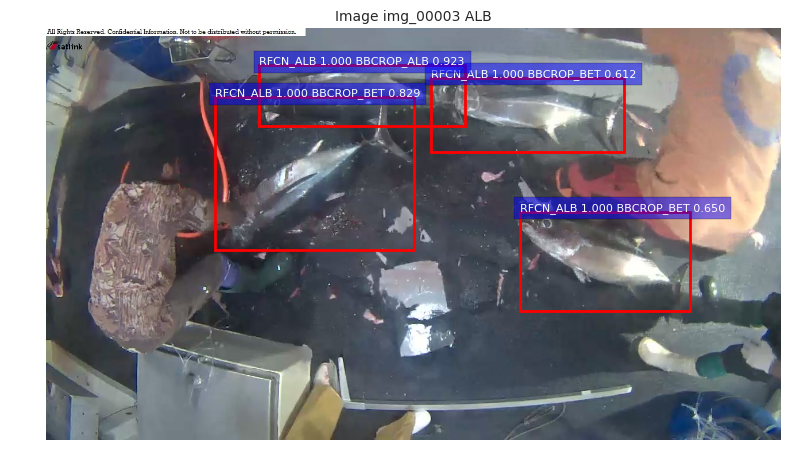

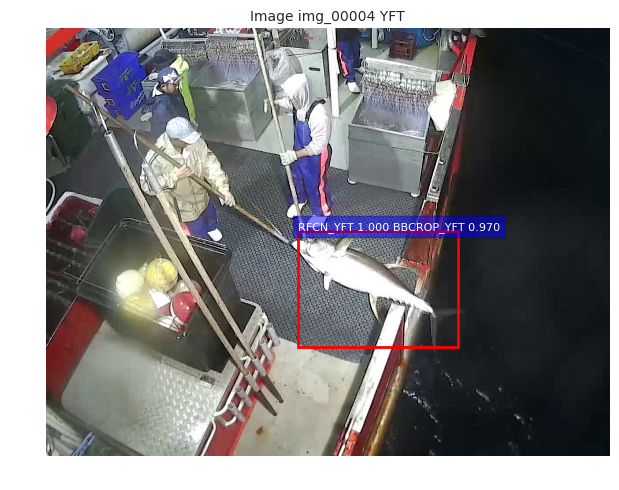

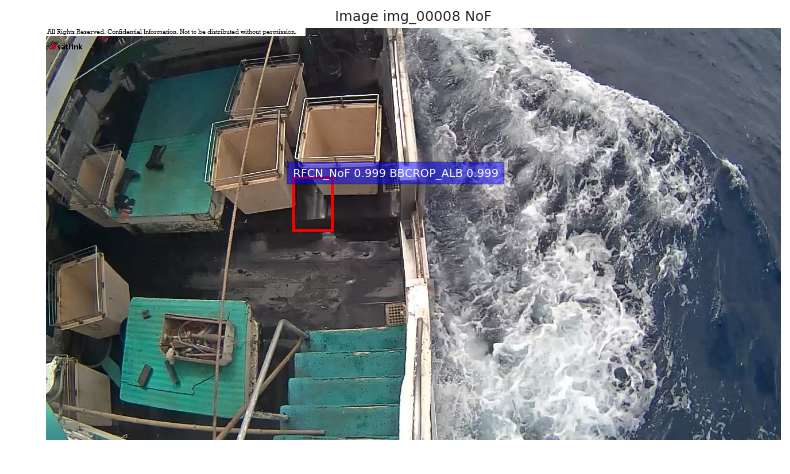

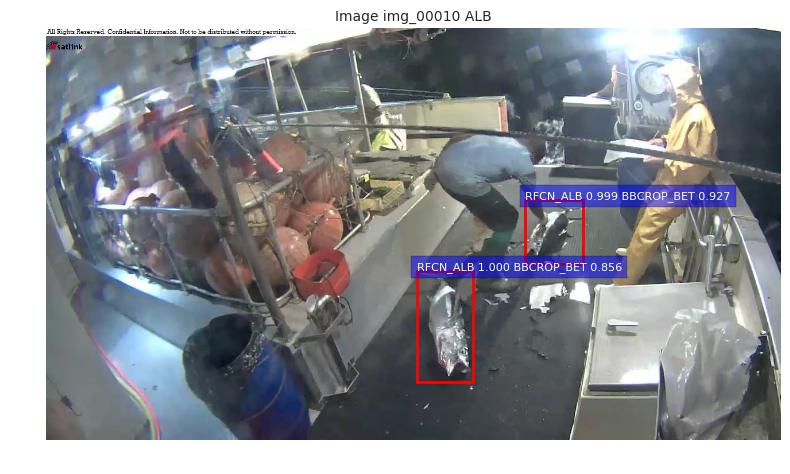

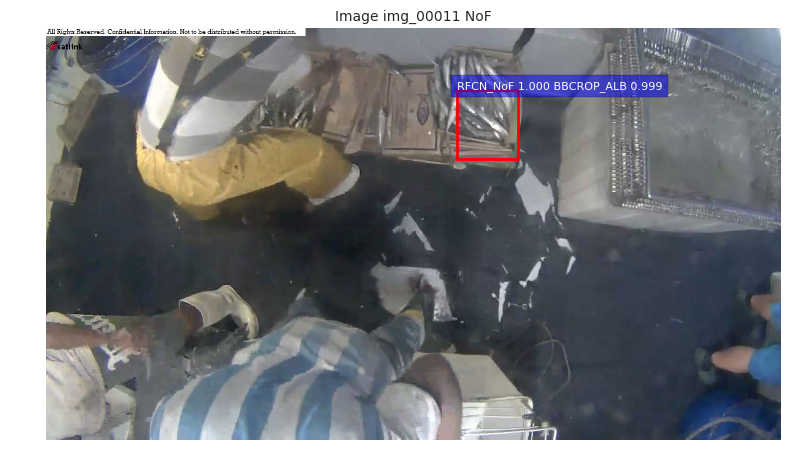

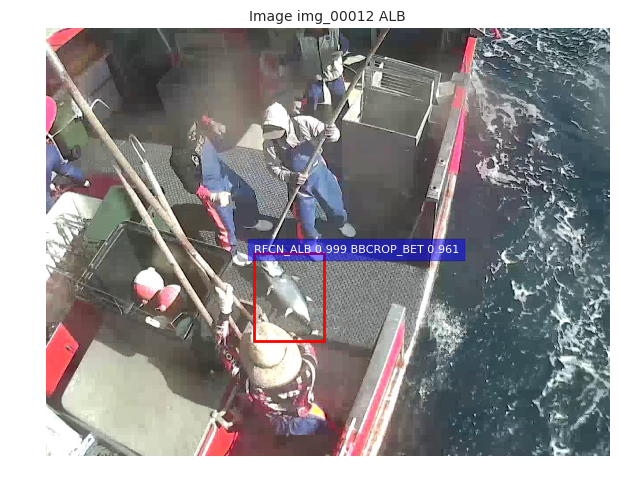

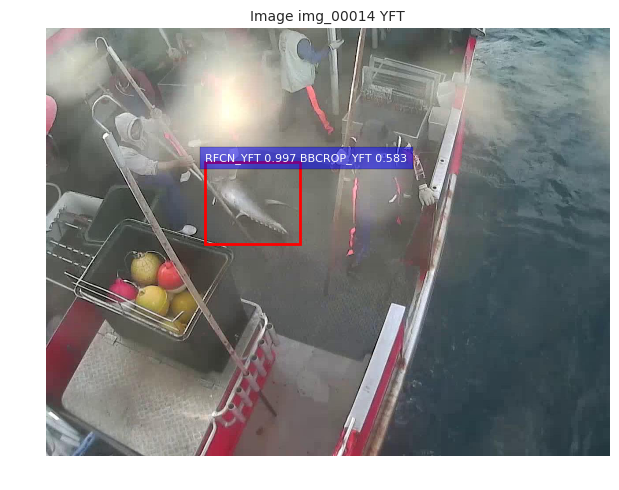

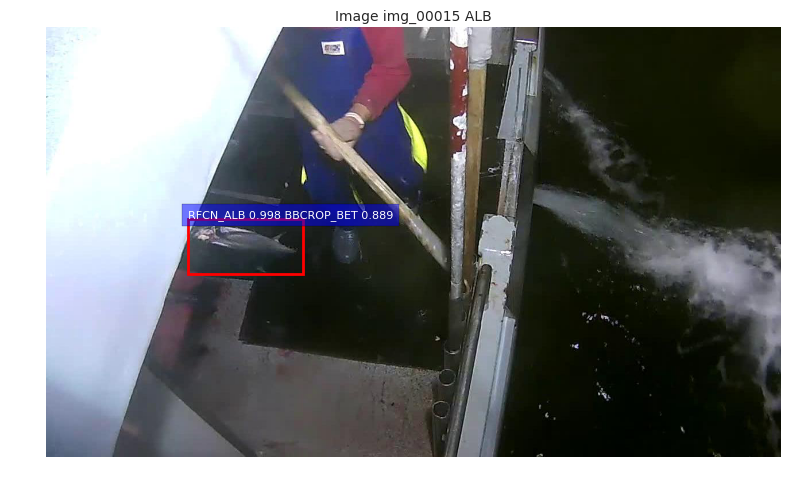

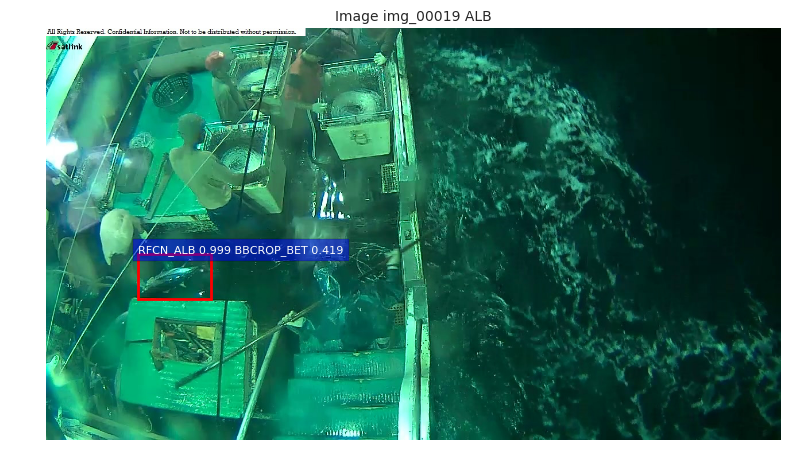

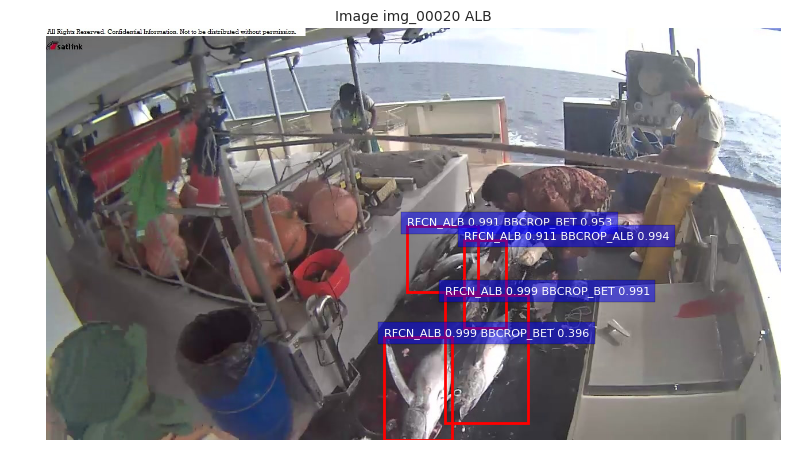

In [126]:
#visualization

FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1] for im in ims][1000:]

for j in range(10):
    dets = test_preds_df.loc[test_preds_df['test_files']==test_files[j]]
    im = Image.open('../RFCN/JPEGImages/'+test_files[j]+'.jpg')
    im = np.asarray(im)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.imshow(im, aspect='equal')
    for index,row in dets.iterrows():
        row = row.tolist()
        bbox = row[5:9]
        RFCN = [row[i] for i in [9,11,13,15,17,19,21,23]]
        BBCROP = [row[i] for i in [18,10,12,14,16,20,22,24]]
        score_RFCN = max(RFCN)
        score_BBCROP = max(BBCROP)
        index_RFCN = RFCN.index(score_RFCN)
        index_BBCROP = BBCROP.index(score_BBCROP)
        class_RFCN = FISH_CLASSES[index_RFCN]
        class_BBCROP = FISH_CLASSES[index_BBCROP]
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='red', linewidth=2))
        ax.text(bbox[0], bbox[1] - 2, 'RFCN_{:s} {:.3f} BBCROP_{:s} {:.3f}'.format(class_RFCN, score_RFCN, class_BBCROP, score_BBCROP), bbox=dict(facecolor='blue', alpha=0.5), fontsize=8, color='white')
    ax.set_title(('Image {:s} {:s}').format(test_files[j], row[1]), fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [110]:
row

test_files                img_00003
gt                              ALB
logloss_RFCN            4.68503e-05
logloss_BBCROP             0.430729
test_crop_files    img_00003_0_.jpg
x0                          825.606
y0                          321.416
x1                          1123.06
y1                          494.048
NoF_RFCN                2.62415e-05
NoF_BBCROP                0.0134631
ALB_RFCN                   0.999953
ALB_BBCROP                 0.650035
BET_RFCN                1.03004e-05
BET_BBCROP               3.0642e-05
DOL_RFCN                2.43886e-08
DOL_BBCROP              3.16039e-05
LAG_RFCN                 1.6326e-07
LAG_BBCROP                 0.303847
OTHER_RFCN              9.48432e-06
OTHER_BBCROP            0.000205742
SHARK_RFCN               6.3092e-08
SHARK_BBCROP            4.22553e-06
YFT_RFCN                5.43256e-07
YFT_BBCROP                0.0323822
Name: 1251, dtype: object

In [ ]:
counts = test_preds_df.groupby('gt').size()
counts

In [31]:
#test preds clsMaxAve
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# files = glob.glob('./checkpoints/checkpoint2/*')
# val_losses = [float(f.split('-')[-1][:-5]) for f in files]
# index = val_losses.index(min(val_losses))
# print('Loading model from', files[index])
# model = load_model(files[index])
print('Loading model from weights.004-0.0565.hdf5')
model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')

test_crop_preds = model.predict(X_test_crop, batch_size=BatchSize, verbose=1)
#test_crop_preds = np.vstack(outputs)[:,4:]

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

count = np.zeros(len(test_files))

test_preds = np.ndarray((len(test_files), test_crop_preds.shape[1]), dtype=np.float32)
for j in range(len(test_files)):
    if j%1000 == 0:
        print(j)
    file = test_files[j]
    test_preds_im = []
    for i in range(len(test_crop_files)):
        if test_crop_files[i][:9] == file[:9]:
            test_preds_im.append(test_crop_preds[i])
    test_preds_im = np.asarray(test_preds_im)
    score_max = np.max(test_preds_im, axis=1)
    inds = np.argmax(test_preds_im, axis=1)
    labels = [FISH_CLASSES[ind] for ind in inds]
    columns = FISH_CLASSES[:]
    test_preds_im_df = pd.DataFrame(test_preds_im, columns=columns)
    test_preds_im_df['max_cls'] = labels
    test_preds_im_df['max_score'] = score_max 
    test_preds_im_df['Counts'] = test_preds_im_df.groupby(['max_cls'])['max_cls'].transform('count')
    idx = test_preds_im_df.groupby(['max_cls'])['max_score'].transform(max) == test_preds_im_df['max_score']
    test_preds_im_df = test_preds_im_df[idx]
    count[j] = test_preds_im_df.shape[0]
    l = FISH_CLASSES.copy()
    l.append('Counts')
    test_preds_im_array = test_preds_im_df[l].as_matrix() 
    test_preds[j] = np.average(test_preds_im_array[:,:-1], axis=0, weights=test_preds_im_array[:,-1], returned=False)

Loading model from weights.003-0.0761.hdf5
6037/6037 [==============================] - 64s    
0
1000
2000
3000
4000


In [33]:
#temperature
T = 2.5
test_preds_T = np.exp(np.log(test_preds)/T)
test_preds_T = test_preds_T/np.sum(test_preds_T, axis=1, keepdims=True)

In [34]:
#calculate train logloss
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
#FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

train_files = test_files[1000:]
train_preds = test_preds_T[1000:,:]
with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()

log_losses = []
for i in range(len(train_preds)):
    im = train_files[i][:-4]
    for im_label in train_file_labels:
        if im_label[:9] == im:
            label = im_label[10:-1]
            index = FISH_CLASSES.index(label)
            log_losses.append(-math.log(train_preds[i,index]))
log_loss = sum(log_losses) / float(len(log_losses))
print('logloss of train is', log_loss )

logloss of train is 0.9195452458092187


In [53]:
#test submission
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
submission = pd.DataFrame(test_preds_T[:1000,:], columns=FISH_CLASSES)
submission.insert(0, 'image', test_files[:1000])

info = 'RFCN_AGONOSTICnms_'+RFCN_MODEL+'_BBCROP_resnet50_clsMaxAve_conf{:.2f}_T{}_'.format(CONF_THRESH, T) + '{:.4f}'.format(log_loss)
sub_file = 'submission_' + info + '.csv'
submission.to_csv(sub_file, index=False)

In [ ]:
###clear checkpoints folder

if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
files = glob.glob('./checkpoints/*')
for f in files:
    os.remove(f)

In [ ]:
###clear logs folder

if not os.path.exists('./logs'):
    os.mkdir('./logs')
files = glob.glob('./logs/*')
for f in files:
    os.remove(f)